# Spam Text Message Classification using NLP

## Let's Get Started 

In [202]:
# import important modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    plot_confusion_matrix,
    f1_score,
    roc_auc_score,
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

# text preprocessing modules
import texthero as hero
from texthero import preprocessing
from nltk.tokenize import word_tokenize

import nltk

from wordcloud import WordCloud, STOPWORDS

# Download dependency
for dependency in (
    "brown",
    "names",
    "wordnet",
    "averaged_perceptron_tagger",
    "universal_tagset",
):
    nltk.download(dependency)
    
from normalise import normalise

import warnings
warnings.filterwarnings("ignore")
# seeding
np.random.seed(123)

[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\DAVIS\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [203]:
# load data
data = pd.read_csv("spam.tsv", sep="\t")

In [204]:
# show top five rows
data.head()

,label,message,length,punct
0,ham,"Go until jurong point, crazy.. Available only ...",111,9
1,ham,Ok lar... Joking wif u oni...,29,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,ham,U dun say so early hor... U c already then say...,49,6
4,ham,"Nah I don't think he goes to usf, he lives aro...",61,2


In [205]:
# check missing values
data.isnull().sum()

label      0
message    0
length     0
punct      0
dtype: int64

In [206]:
# check the shape
data.shape

(5572, 4)

In [207]:
# evalute class distribution
data["label"].value_counts()

ham     4825
spam     747
Name: label, dtype: int64

we have more normal sms than spam sms 

## Data Exploratory

In [208]:
# explore ham labeled sms
def collect_words(data, label):
    collected_words = " "

    # iterate through the csv file
    for val in data.message[data["label"] == label]:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        for words in tokens:
            collected_words = collected_words + words + " "

    return collected_words

Total words 349132


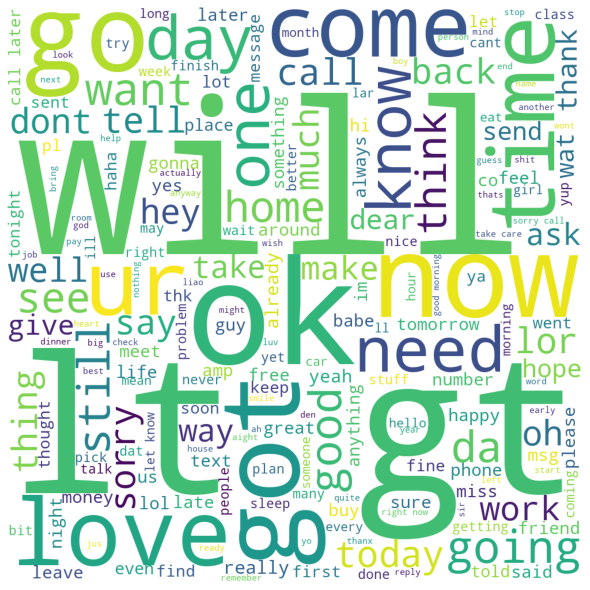

In [209]:
# visualize ham labeled sms
stopwords = set(STOPWORDS)
ham_words = collect_words(data, label="ham")

print("Total words {}".format(len(ham_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(ham_words)

# plot the WordCloud image
plt.figure(figsize=(15, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

Total words 104304


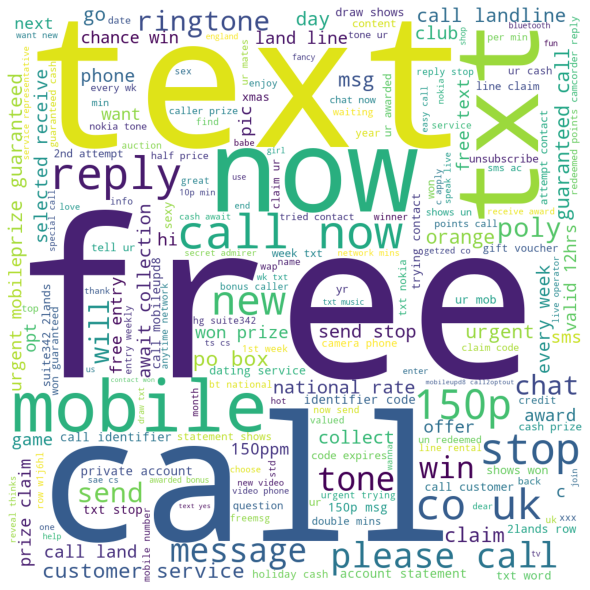

In [210]:
# visualize spam labeled sms
stopwords = set(STOPWORDS)
spam_words = collect_words(data, label="spam")

print("Total words {}".format(len(spam_words)))

wordcloud = WordCloud(
    width=1000,
    height=1000,
    background_color="white",
    stopwords=stopwords,
    min_font_size=10,
).generate(spam_words)

# plot the WordCloud image
plt.figure(figsize=(10, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

In [211]:
# show spam messages
data[data["label"] == "spam"].sample(10)

,label,message,length,punct
879,spam,U have a secret admirer who is looking 2 make ...,132,3
3860,spam,Win the newest Harry Potter and the Order of ...,138,5
3167,spam,HOT LIVE FANTASIES call now 08707509020 Just 2...,101,3
1069,spam,Someone U know has asked our dating service 2 ...,134,3
2220,spam,You have WON a guaranteed £1000 cash or a £200...,154,2
3382,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 ...",149,4
2850,spam,YOUR CHANCE TO BE ON A REALITY FANTASY SHOW ca...,151,3
1940,spam,More people are dogging in your area now. Call...,159,6
5141,spam,FREE for 1st week! No1 Nokia tone 4 ur mobile ...,162,7
2575,spam,Your next amazing xxx PICSFREE1 video will be ...,153,2


In [212]:
# show normal messages
data[data["label"] == "ham"].sample(10)

,label,message,length,punct
4098,ham,i am going to bed now prin,26,0
4549,ham,Hope you are having a good week. Just checking in,49,1
168,ham,"Hi frnd, which is best way to avoid missunders...",74,3
4677,ham,Ü ready then call me...,23,3
4420,ham,How have your little darlings been so far this...,122,4
1315,ham,Got but got 2 colours lor. One colour is quite...,122,5
1348,ham,She doesnt need any test.,25,1
3105,ham,That's y i said it's bad dat all e gals know u...,66,6
112,ham,Going for dinner.msg you after.,31,2
4308,ham,I guess it is useless calling u 4 something im...,54,1


### Data Preparation 

In [213]:
# replace ham to 0 and spam to 1
new_data = data.replace({"ham": 0, "spam": 1})
new_data.head()

,label,message,length,punct
0,0,"Go until jurong point, crazy.. Available only ...",111,9
1,0,Ok lar... Joking wif u oni...,29,6
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,6
3,0,U dun say so early hor... U c already then say...,49,6
4,0,"Nah I don't think he goes to usf, he lives aro...",61,2


In [214]:
# create a class for clean text data
class CleanMessages(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):

        # custom cleaning
        custom_pipeline = [
            preprocessing.fillna,
            preprocessing.lowercase,
            preprocessing.remove_digits,
            preprocessing.remove_whitespace,
            preprocessing.remove_punctuation,
            preprocessing.remove_urls,
            preprocessing.remove_angle_brackets,
            preprocessing.remove_curly_brackets,
            preprocessing.remove_round_brackets,
            preprocessing.remove_square_brackets,
            preprocessing.stem,
        ]

        X = X.pipe(hero.clean, custom_pipeline)

        return X

In [215]:
# testing the cleanMessages class
cm = CleanMessages()
clean_message = cm.fit_transform(new_data["message"])
clean_message.head()

0    go until jurong point crazi avail onli in bugi...
1                                ok lar joke wif u oni
2    free entri in a wkli comp to win fa cup final ...
3          u dun say so earli hor u c alreadi then say
4    nah i don t think he goe to usf he live around...
Name: message, dtype: object

In [216]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    new_data["message"],
    new_data["label"],
    test_size=0.15,
    random_state=0,
    shuffle=True,
    stratify=data["label"],
)

### Pipeline and Classifier 

In [217]:
# Create a pipeline combing the preprocessing methods and estimator

spam_classifier = Pipeline(
    [
        ("clean_messages", CleanMessages()),
        ("tfidf", TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2))),
        ("clf", MultinomialNB()),
    ]
)

In [218]:
# Train the model with cross validation
scores = cross_val_score(spam_classifier,X_train,y_train,cv=10,verbose=3,n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   28.9s remaining:   12.3s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   31.1s finished


In [219]:
# find the mean of the all scores
scores.mean()

0.9575561324163031

In [220]:
# fine turning model parameters

distribution = {"clf__alpha": [1, 0.1, 0.01, 0.001, 0.0001, 0, 0.2, 0.3]}

grid = RandomizedSearchCV(
    clf_rf,
    param_distributions=distribution,
    n_jobs=-1,
    cv=5,
    n_iter=20,
    random_state=42,
    return_train_score=True,
    verbose=2,
)

In [221]:
# training with randomized search
grid.fit(X_train, y_train, )

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   47.8s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   53.4s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('clean_messages',
                                              CleanMessages()),
                                             ('tfidf',
                                              TfidfVectorizer(ngram_range=(1,
                                                                           2),
                                                              stop_words={'a',
                                                                          'about',
                                                                          'above',
                                                                          'after',
                                                                          'again',
                                                                          'against',
                                                                          'all',
                                                          

In [222]:
# summarize the results of the random parameter search
print(grid.best_score_)
print(grid.best_estimator_)
print(grid.best_params_)

0.9866986129861566
Pipeline(steps=[('clean_messages', CleanMessages()),
                ('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'all', 'also',
                                             'am', 'an', 'and', 'any', 'are',
                                             "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             "can't", 'cannot', 'com', ...})),
                ('clf', MultinomialNB(alpha=0.1))])
{'clf__alpha': 0.1}


In [227]:
# Train the model with best parameters

best_classifier = Pipeline(
    [
        ("clean_messages", CleanMessages()),
        ("tfidf", TfidfVectorizer(stop_words=stopwords, ngram_range=(1, 2))),
        ("clf", MultinomialNB(alpha=0.1)),
    ]
)

In [228]:
#cross validation
scores = cross_val_score(best_classifier, X_train, y_train, cv=10, verbose=2, n_jobs=-1)

print(scores)
print(scores.mean())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[0.98101266 0.98523207 0.99156118 0.98523207 0.98312236 0.99578059
 0.98731501 0.99154334 0.98731501 0.98308668]
0.9871200970553339


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.2s finished


In [231]:
# train the best_classifier 
best_classifier.fit(X_train,y_train)

Pipeline(steps=[('clean_messages', CleanMessages()),
                ('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'all', 'also',
                                             'am', 'an', 'and', 'any', 'are',
                                             "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             "can't", 'cannot', 'com', ...})),
                ('clf', MultinomialNB(alpha=0.1))])

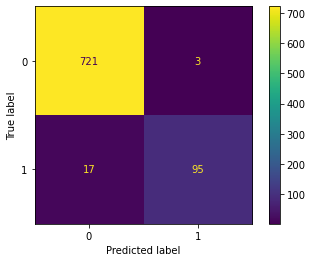

In [232]:
# plot the comfusion matrix
plot_confusion_matrix(best_classifier, X_test, y_test, normalize=None)

In [233]:
# predict on the test data
y_pred = best_classifier.predict(X_test)

In [234]:
# check the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       724
           1       0.97      0.85      0.90       112

    accuracy                           0.98       836
   macro avg       0.97      0.92      0.95       836
weighted avg       0.98      0.98      0.98       836



In [235]:
# check accuracy score
accuracy_score(y_test, y_pred)

0.9760765550239234

In [236]:
# check f1_ score
f1_score(y_test, y_pred)

0.9047619047619048

In [237]:
# test on the ham message
new_message = pd.Series(np.array(['Hey, how are you?']))
best_classifier.predict(new_message)

array([0], dtype=int64)

In [238]:
# test on spam message
new_message_2 = pd.Series(np.array(['You have WON a guaranteed £1000 cash or a £200.']))
best_classifier.predict(new_message_2)

array([1], dtype=int64)

In [239]:
#save model 
import joblib 

joblib.dump(best_classifier, 'models/spam_detection_model.pkl')

['models/spam_detection_model.pkl']

In [240]:
#load model and predict 
spam_detector = joblib.load("models/spam_detection_model.pkl")

spam_detector 

Pipeline(steps=[('clean_messages', CleanMessages()),
                ('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words={'a', 'about', 'above', 'after',
                                             'again', 'against', 'all', 'also',
                                             'am', 'an', 'and', 'any', 'are',
                                             "aren't", 'as', 'at', 'be',
                                             'because', 'been', 'before',
                                             'being', 'below', 'between',
                                             'both', 'but', 'by', 'can',
                                             "can't", 'cannot', 'com', ...})),
                ('clf', MultinomialNB(alpha=0.1))])

In [241]:
# predict on new messge 

spam_detector.predict(pd.Series(np.array("FREE for 1st week! No1 Nokia tone 4 ur mobile .")))

array([1], dtype=int64)